# RL-based HVAC Control: Full Workflow

**Goals:**
1. 70/30 train-test split  
2. Percentile-based action thresholds  
3. λ-weighted reward  
4. SAC tuning (Random, Grid, Bayesian) on **train** set  
5. Evaluation on **test** set: compare against a baseline, plot energy & comfort, compute savings  


In [2]:

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.9 MB/s eta 0:00:00


Imports

In [12]:
import random, itertools
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from collections import deque

Data Loading & Preprocessing

In [13]:
def preprocess_data(df):
    df['Occupancy']   = (df['lights'] > 0).astype(int)
    temp_cols         = [f'T{i}' for i in range(1,10)]
    df['Avg_T1_T9']   = df[temp_cols].mean(axis=1)
    df['HVAC_energy'] = df['Appliances'] - df['lights']
    df['date']        = pd.to_datetime(df['date'])
    df['Hour_of_day'] = df['date'].dt.hour
    df = df[['Avg_T1_T9','T_out','Occupancy','Hour_of_day','HVAC_energy']]
    df.ffill(inplace=True)
    return df

raw = pd.read_csv("/content/raw_data.csv")
processed_df = preprocess_data(raw)

<ipython-input-13-bf64bfcca8ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)


Train/Test Split & Percentile Thresholds

In [15]:
train_df, test_df = train_test_split(processed_df, test_size=0.3, shuffle=False)
hvac_vals = train_df['HVAC_energy'].values
p0, p25, p50, p75 = np.percentile(hvac_vals, [0,25,50,75])
thresholds = [(p0,p25), (p25,p50), (p50,p75), (p75, hvac_vals.max())]
print("Action thresholds (Wh):", thresholds)


Action thresholds (Wh): [(np.float64(0.0), np.float64(50.0)), (np.float64(50.0), np.float64(60.0)), (np.float64(60.0), np.float64(90.0)), (np.float64(90.0), np.int64(1050))]


Environment Class with λ-Weighted Reward

In [16]:
class HVACEnvironment:
    def __init__(self, df, desired_temp=22):
        self.df = df.reset_index(drop=True)
        self.desired_temp = desired_temp
        self.max_steps = len(df) - 1

    def reset(self, step=0):
        self.current_step = step
        self.current_temp = self.df['Avg_T1_T9'].iloc[step]
        return self._get_state()

    def _get_state(self):
        row = self.df.iloc[self.current_step].copy()
        row['Avg_T1_T9'] = self.current_temp
        return row.values

    def step(self, action):
        # placeholder—won't be used directly
        return None

# 5️⃣ EXTENDED ENVIRONMENT WITH λ & THRESHOLDS (fix included)

In [17]:
class HVACEnvironmentWithThreshold(HVACEnvironment):
    def __init__(self, df, thresholds, λ=1.0, desired_temperature=22):
        super().__init__(df, desired_temperature)
        self.thresholds = thresholds
        self.λ = λ
        # add these so SACAgent/train_sac can read them:
        self.observation_space_shape = df.shape[1]
        self.action_space_n = len(thresholds)

    def _take_action(self, action):
        low, high = self.thresholds[action]
        return np.random.uniform(low, high)

    def step(self, action):
        energy = self._take_action(action)
        # update indoor temp
        self.current_temp += ((self.desired_temp - self.current_temp)
                              * 0.05 * (energy / (self.thresholds[action][1] or 1e-5)))
        self.current_step += 1
        temp_dev = abs(self.current_temp - self.desired_temp)
        reward = -(energy + self.λ * temp_dev)
        done = self.current_step >= self.max_steps
        return self._get_state(), reward, done, {'energy': energy}

# 6️⃣ REPLAY BUFFER

In [18]:
class ReplayBuffer:
    def __init__(self, capacity=100_000): self.buffer = deque(maxlen=capacity)
    def push(self, *args): self.buffer.append(args)
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s,a,r,s2,d = zip(*batch)
        return (torch.FloatTensor(s),
                torch.LongTensor(a),
                torch.FloatTensor(r),
                torch.FloatTensor(s2),
                torch.FloatTensor(d))
    def __len__(self): return len(self.buffer)

# 7️⃣ SAC AGENT

In [19]:
class SACAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=0.2, lr=3e-4):
        self.gamma, self.alpha = gamma, alpha
        self.q1 = nn.Sequential(nn.Linear(state_dim,128), nn.ReLU(), nn.Linear(128,action_dim))
        self.q2 = nn.Sequential(nn.Linear(state_dim,128), nn.ReLU(), nn.Linear(128,action_dim))
        self.policy = nn.Sequential(nn.Linear(state_dim,128), nn.ReLU(),
                                    nn.Linear(128,action_dim), nn.Softmax(dim=-1))
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=lr)
        self.pol_opt= optim.Adam(self.policy.parameters(), lr=lr)
        self.buffer = ReplayBuffer()

    def select_action(self, state):
        probs = self.policy(torch.FloatTensor(state).unsqueeze(0)).detach().numpy()[0]
        return np.random.choice(len(probs), p=probs)

    def store(self, *args): self.buffer.push(*args)

    def update(self, batch_size=64):
        if len(self.buffer) < batch_size: return
        s,a,r,s2,d = self.buffer.sample(batch_size)
        q1 = self.q1(s).gather(1, a.unsqueeze(1)).squeeze()
        q2 = self.q2(s).gather(1, a.unsqueeze(1)).squeeze()
        with torch.no_grad():
            p2 = self.policy(s2)
            minq = torch.min(self.q1(s2), self.q2(s2))
            ent = -torch.sum(p2 * torch.log(p2 + 1e-10), dim=1)
            tgt = r + self.gamma*(1-d)*torch.sum(p2*minq,1) + self.alpha*ent
        loss1 = nn.MSELoss()(q1, tgt)
        loss2 = nn.MSELoss()(q2, tgt)
        self.q1_opt.zero_grad(); loss1.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); loss2.backward(); self.q2_opt.step()
        pol_loss = -torch.mean(torch.sum(self.policy(s)*self.q1(s),1))
        self.pol_opt.zero_grad(); pol_loss.backward(); self.pol_opt.step()

# 8️⃣ BASELINE CONTROLLER

In [20]:
def baseline_action(current_temp, desired_temp=22):
    if current_temp < desired_temp - 1: return 3
    if current_temp > desired_temp + 1: return 0
    return 1

# 9️⃣ SIMULATION FUNCTION

In [21]:
def simulate_control(env, agent, controller="sac", steps=1000, cost_per_kwh=0.12):
    env.reset(0)
    energies, deviations = [], []
    for _ in range(steps):
        if env.current_step >= env.max_steps: break
        s = env._get_state()
        a = agent.select_action(s) if controller=="sac" else baseline_action(env.current_temp)
        _, _, _, info = env.step(a)
        energies.append(info['energy'])
        deviations.append(abs(env.current_temp - env.desired_temp))
    total_e = sum(energies)
    total_c = total_e * cost_per_kwh / 1000
    return energies, deviations, total_e, total_c

# 🔟 TRAINING FUNCTIONS

In [22]:
def train_sac(env, params, episodes=5):
    agent = SACAgent(env.observation_space_shape, env.action_space_n,
                     gamma=params["gamma"], alpha=params["alpha"], lr=params["lr"])
    ep_rewards = []
    for _ in range(episodes):
        s, done, ep_r = env.reset(), False, 0
        while not done:
            a = agent.select_action(s)
            s2, r, done, _ = env.step(a)
            agent.store(s,a,r,s2,done); agent.update()
            s, ep_r = s2, ep_r + r
        ep_rewards.append(ep_r)
    return np.mean(ep_rewards)

def run_random_search(env, trials=5):
    best,bp = -np.inf, None
    for _ in range(trials):
        p = {"gamma": np.random.uniform(0.9,0.99),
             "alpha": np.random.uniform(0.1,0.5),
             "lr": 10**np.random.uniform(-5,-3)}
        r = train_sac(env,p)
        print("Random",p,"→",r)
        if r>best: best,bp = r,p
    print("Best Random",bp,best); return bp

def run_grid_search(env):
    best,bp = -np.inf, None
    for g,a_,l in itertools.product([0.95,0.97,0.99],[0.2,0.3],[1e-4,5e-4]):
        p={"gamma":g,"alpha":a_,"lr":l}; r=train_sac(env,p)
        print("Grid",p,"→",r)
        if r>best: best,bp = r,p
    print("Best Grid",bp,best); return bp

def objective(trial):
    p = {"gamma": trial.suggest_float("gamma",0.9,0.99),
         "alpha": trial.suggest_float("alpha",0.1,0.5),
         "lr": trial.suggest_float("lr",1e-5,1e-3,log=True)}
    return train_sac(global_env,p)

def run_bayesian_optimization(env, n_trials=10):
    global global_env; global_env = env
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    print("Best Optuna", study.best_params, study.best_value)
    return study.best_params

# 1️⃣1️⃣ RUN TUNING ON TRAIN SET

In [23]:
train_env = HVACEnvironmentWithThreshold(train_df, thresholds, λ=1.5)
best_random = run_random_search(train_env)
best_grid   = run_grid_search(train_env)
best_optuna = run_bayesian_optimization(train_env)

<ipython-input-18-bae26024f752>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return (torch.FloatTensor(s),


Random {'gamma': 0.9474129095174042, 'alpha': 0.2697276847258997, 'lr': 3.4122098515562356e-05} → -424089.4488386358
Random {'gamma': 0.9174608781037871, 'alpha': 0.34490723031158277, 'lr': 0.0006623398104907857} → -353465.6853288563
Random {'gamma': 0.9334659682039912, 'alpha': 0.19822812873463003, 'lr': 0.00010753978166519385} → -360763.61256083846
Random {'gamma': 0.9183724544285999, 'alpha': 0.25858862443792063, 'lr': 0.00016523151327433442} → -368754.15724383463
Random {'gamma': 0.9346094437345104, 'alpha': 0.3849749281963092, 'lr': 0.0007859280317779801} → -347957.60210269614
Best Random {'gamma': 0.9346094437345104, 'alpha': 0.3849749281963092, 'lr': 0.0007859280317779801} -347957.60210269614
Grid {'gamma': 0.95, 'alpha': 0.2, 'lr': 0.0001} → -390657.22404528206
Grid {'gamma': 0.95, 'alpha': 0.2, 'lr': 0.0005} → -904862.4796568903
Grid {'gamma': 0.95, 'alpha': 0.3, 'lr': 0.0001} → -426423.06002122565
Grid {'gamma': 0.95, 'alpha': 0.3, 'lr': 0.0005} → -363209.3092351942
Grid {'ga

[I 2025-04-23 17:44:28,451] A new study created in memory with name: no-name-f67e2e4a-4237-4c97-b462-ef37de54e845


Grid {'gamma': 0.99, 'alpha': 0.3, 'lr': 0.0005} → -771298.9252212021
Best Grid {'gamma': 0.97, 'alpha': 0.3, 'lr': 0.0005} -348876.14715796366


[I 2025-04-23 17:50:18,620] Trial 0 finished with value: -396568.94727726455 and parameters: {'gamma': 0.9283750797832272, 'alpha': 0.45125627293452164, 'lr': 0.0003422553957624337}. Best is trial 0 with value: -396568.94727726455.
[I 2025-04-23 17:56:09,701] Trial 1 finished with value: -511754.02538036613 and parameters: {'gamma': 0.9776425039894331, 'alpha': 0.15536843499509698, 'lr': 1.6087775576653797e-05}. Best is trial 0 with value: -396568.94727726455.
[I 2025-04-23 18:02:04,137] Trial 2 finished with value: -383329.6958842002 and parameters: {'gamma': 0.9021288783477043, 'alpha': 0.1322902908646457, 'lr': 3.601280953002883e-05}. Best is trial 2 with value: -383329.6958842002.
[I 2025-04-23 18:07:53,510] Trial 3 finished with value: -395566.4267991416 and parameters: {'gamma': 0.9065444040453128, 'alpha': 0.31088809775843984, 'lr': 0.0003316476644378618}. Best is trial 2 with value: -383329.6958842002.
[I 2025-04-23 18:13:49,433] Trial 4 finished with value: -429827.28601657704

Best Optuna {'gamma': 0.9339637286348161, 'alpha': 0.3513574757887926, 'lr': 0.00045457729427217635} -355874.726871061


# 1️⃣2️⃣ EVALUATE ON TEST SET

In [24]:
test_env = HVACEnvironmentWithThreshold(test_df, thresholds, λ=1.5)
agent    = SACAgent(test_env.observation_space_shape, test_env.action_space_n,
                    gamma=best_optuna["gamma"],
                    alpha=best_optuna["alpha"],
                    lr=best_optuna["lr"])
sac_eng, sac_dev, sac_E, sac_cost     = simulate_control(test_env, agent, "sac")
base_eng, base_dev, base_E, base_cost = simulate_control(test_env, agent, "baseline")

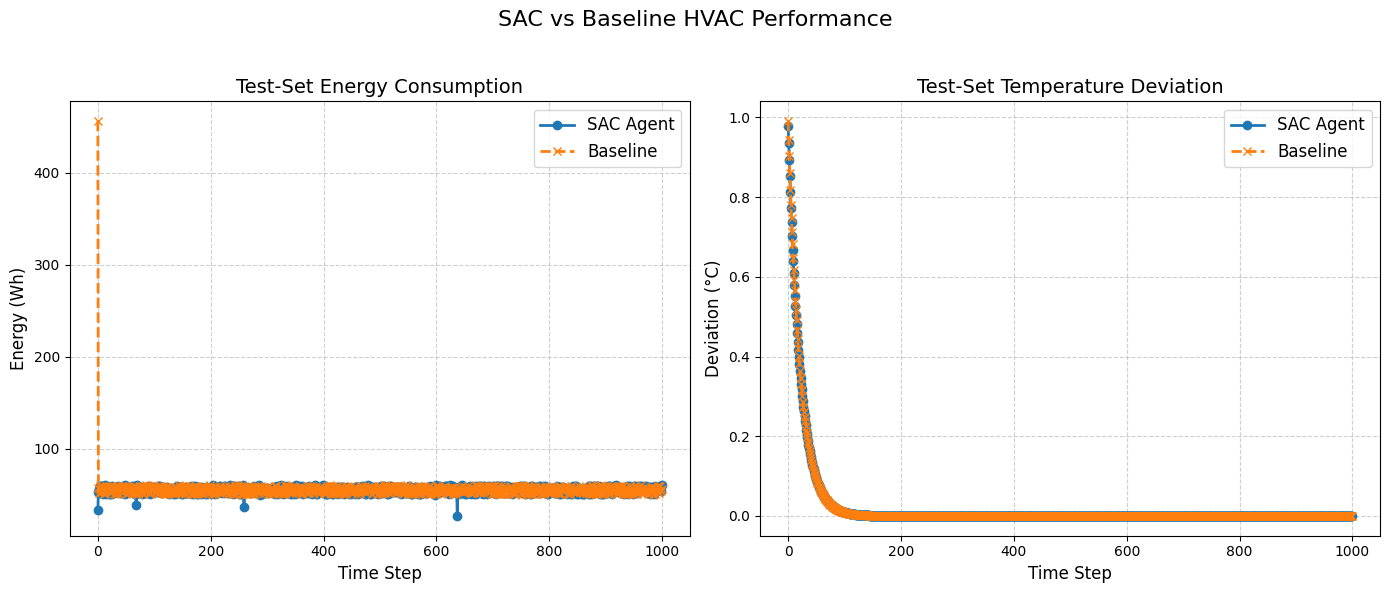

In [28]:
import matplotlib.pyplot as plt

# Create a figure with two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Energy Consumption (left)
ax1.plot(sac_eng, marker='o', linestyle='-', linewidth=2, label='SAC Agent')
ax1.plot(base_eng, marker='x', linestyle='--', linewidth=2, label='Baseline')
ax1.set_title("Test-Set Energy Consumption", fontsize=14)
ax1.set_xlabel("Time Step", fontsize=12)
ax1.set_ylabel("Energy (Wh)", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=12)

# Temperature Deviation (right)
ax2.plot(sac_dev, marker='o', linestyle='-', linewidth=2, label='SAC Agent')
ax2.plot(base_dev, marker='x', linestyle='--', linewidth=2, label='Baseline')
ax2.set_title("Test-Set Temperature Deviation", fontsize=14)
ax2.set_xlabel("Time Step", fontsize=12)
ax2.set_ylabel("Deviation (°C)", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=12)

# Overall title and layout tweak
fig.suptitle("SAC vs Baseline HVAC Performance", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 1️⃣3️⃣ PLOT & PRINT RESULTS

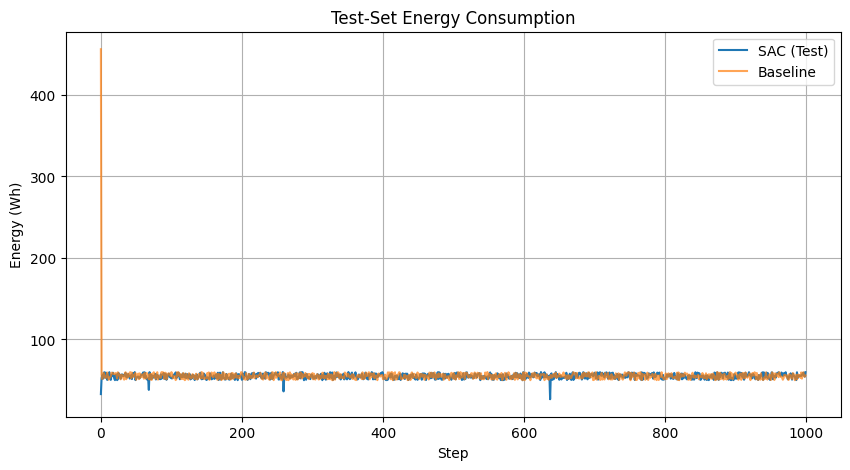

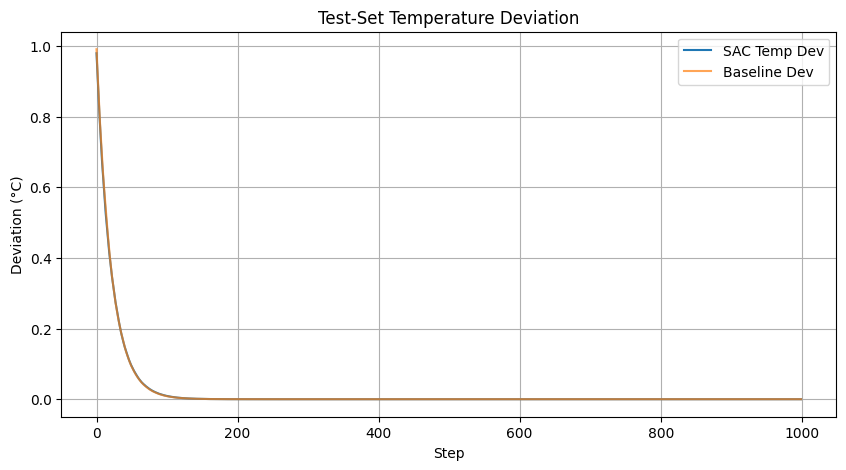

🔋 SAC Energy:     54890.82 Wh
🔋 Baseline Energy:55377.62 Wh
🔋 Energy Saved:   486.80 Wh (0.49 kWh)

💰 SAC Cost:       $6.59
💰 Baseline Cost:  $6.65
💰 Cost Saved:     $0.06


In [27]:
plt.figure(figsize=(10,5))
plt.plot(sac_eng, label="SAC (Test)")
plt.plot(base_eng, label="Baseline", alpha=0.7)
plt.title("Test-Set Energy Consumption"); plt.xlabel("Step"); plt.ylabel("Energy (Wh)")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(sac_dev, label="SAC Temp Dev")
plt.plot(base_dev, label="Baseline Dev", alpha=0.7)
plt.title("Test-Set Temperature Deviation"); plt.xlabel("Step"); plt.ylabel("Deviation (°C)")
plt.legend(); plt.grid(True); plt.show()

saved_wh  = base_E - sac_E
saved_kwh = saved_wh / 1000
saved_cost= base_cost - sac_cost

print(f"🔋 SAC Energy:     {sac_E:.2f} Wh")
print(f"🔋 Baseline Energy:{base_E:.2f} Wh")
print(f"🔋 Energy Saved:   {saved_wh:.2f} Wh ({saved_kwh:.2f} kWh)\n")
print(f"💰 SAC Cost:       ${sac_cost:.2f}")
print(f"💰 Baseline Cost:  ${base_cost:.2f}")
print(f"💰 Cost Saved:     ${saved_cost:.2f}")